This example is the simplest form of using an RBF kernel in an `VariationalGP` module
- When you want to use variation inference (e.g. for classification)
- When no fancy techniques are required

In this example, we’re modeling a unit wave with period 1/2 centered with positive values @ x=0

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from torch.autograd import Variable
# Grid points are [0,1] every 1/9
train_x = Variable(torch.linspace(0, 1, 10))
# Labels are unit wave with period 1/2 centered with positive values @ x=0
train_y = Variable(torch.sign(torch.cos(train_x.data * (4 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
# Basic classification model with variational inference
class GPClassificationModel(gpytorch.models.VariationalGP):
    def __init__(self, train_inputs):
        super(GPClassificationModel, self).__init__(train_inputs)
        # Only non-zero mean function can be learned
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # Use universal approximator RBF kernel
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Get predictive mean and covariance
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Scale covariance
        covar_x = covar_x.mul(self.log_outputscale.exp().expand_as(covar_x))
        # Package prediction as GaussianRandomVariable
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        # Return predictions
        return latent_pred

# Initialize model and likelihood
model = GPClassificationModel(train_x.data)
likelihood = BernoulliLikelihood()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use Adam optimizer on model parameters (Bernoulli likelihood doesn't have parameters)
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
training_iter = 50
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()

Iter 1/50 - Loss: 266.578   log_lengthscale: 0.000
Iter 2/50 - Loss: 241.063   log_lengthscale: -0.100
Iter 3/50 - Loss: 139.192   log_lengthscale: -0.195
Iter 4/50 - Loss: 86.837   log_lengthscale: -0.287
Iter 5/50 - Loss: 60.454   log_lengthscale: -0.378
Iter 6/50 - Loss: 31.666   log_lengthscale: -0.471
Iter 7/50 - Loss: 25.879   log_lengthscale: -0.563
Iter 8/50 - Loss: 18.036   log_lengthscale: -0.653
Iter 9/50 - Loss: 11.823   log_lengthscale: -0.742
Iter 10/50 - Loss: 16.754   log_lengthscale: -0.828
Iter 11/50 - Loss: 14.458   log_lengthscale: -0.914
Iter 12/50 - Loss: 12.708   log_lengthscale: -0.998
Iter 13/50 - Loss: 10.416   log_lengthscale: -1.078
Iter 14/50 - Loss: 8.523   log_lengthscale: -1.154
Iter 15/50 - Loss: 13.392   log_lengthscale: -1.229
Iter 16/50 - Loss: 9.890   log_lengthscale: -1.300
Iter 17/50 - Loss: 6.080   log_lengthscale: -1.370
Iter 18/50 - Loss: 6.433   log_lengthscale: -1.438
Iter 19/50 - Loss: 6.510   log_lengthscale: -1.504
Iter 20/50 - Loss: 4.195

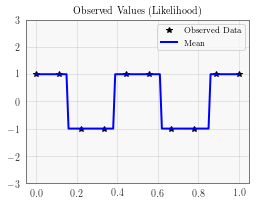

In [6]:
# Go into eval mode
model.eval()
likelihood.eval()

# Initialize fig and axes for plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test x are regularly spaced by 0.01 0,1 inclusive
test_x = Variable(torch.linspace(0, 1, 101))
## Not sure why this is with... Get Bernoulli prediction
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Plotting function
# A lot of this should be consolidated as helper between different notebooks
def ax_plot(ax, rand_var, title):
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot square wave predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')